## Code and Documentation to Decode Popup Buoy Transmitted/Recorded Data

## Software Requirements

Developed/tested for:
- python >=3.6 

requires:
- pyyaml >= 3.13 
- pandas >= 0.23.4
- numpy >= 1.15.4
- holoviews >= 1.10.9
- matplotlib >= 3.0.2
- bokeh >= 1.0.2
- jupyterlab >= 1.0.0 (jupyter + holoviews plugin)

## Data Structure

Data downloaded from Popup Buoy's directly, generate 8 binary files.  A complete description of these files can be found at **[link]**.  Relevant pieces will be included in the notebook.

Filenames:
- BOTDAT.TXT
- FILEPOS.TXT
- ICEDAT.TXT
- JPGxxxxx.JPG
- PRODAT.TXT
- SSTDAT.TXT
- SUMMARY.TXT

In [75]:
instid = '300434063925210'
year = '2019'
instfile_dic = {'bot_file': instid+'/'+year+'/BOTDAT.TXT',
                'ice_file': instid+'/'+year+'/ICEDAT.TXT',
                'pro_file': instid+'/'+year+'/PRODAT.TXT',
                'sst_file': instid+'/'+year+'/SSTDAT.TXT'}
instconfig = '300434063925210.yaml'

For each data file, we are going to read in the entire file and convert the binary to hex.  There are multiple line, lengths we are going to have to address but the start of each record is denoted by 'FFFF'.  We can split the filestring on this parameter but we need to be aware of 'FFFFF' or 'FFFFFF' posibilities

***Basic Approach***

The two modules below will allow for a simple readin of the file for very simple analysis and debugging... the code of consequence that involves conversion of measurements from engineering units to science units as all defined in the PopUpBuoy CLASS in the next section

In [76]:
def HexView(file):
    with open(file, 'rb') as in_file:
        while True:
            hexdata = in_file.read().hex().upper()     # Read the shortest possible line
            if len(hexdata) == 0:                      # breaks loop once no more binary data is read
                break
            
            return(hexdata.upper())
        
def HexSplit(hexstr):
    if hexstr.find('FFFFF') == -1:
        print("No FFFFF, proceed to split on FFFF")
        sample_raw = hexstr.split('FFFF')[1:]
    else:
        print('FFFFF found')
        #this puts in the proper line endings but removes a variable 
        #   F from the end of each string.  Add the F string back
        sample_raw = []
        for substr in hexstr.split('FFFFF')[1:]: 
            sample_raw = sample_raw + (substr + 'F').split('FFFF')

        sample_raw[-1] = sample_raw[-1][:-1]
        
    return(sample_raw)

In [77]:
active_file = instfile_dic['bot_file']

hexstr = HexView(active_file)
sample_raw = HexSplit(hexstr)


FFFFF found


# Class description and routine code

## Decode sample data for each file type

### Bottom Data (BOTDAT.TXT) / Under Ice Data (ICEDAT.TXT)

This data has two record lengths.  17 and 19.  Since we've split on 'FFFF' and broken the record up into samples, the initial 2bytes are no longer in the record so the record lengths are now 15 and 17 (which is a string length of 30 and 34 characters)

***MSG Decode Key***
![BotDecodeMsg](decode_images/BotDat_msg_decode.png)

***Engineering to Science Conversions***
![BotDecodeMsg](decode_images/BotDat_msg_cal.png)


### Profile Data (PRODAT.TXT) /

This data has two record lengths.  13 and 15.  Since we've split on 'FFFF' and broken the record up into samples, the initial 2bytes are no longer in the record so the record lengths are now 11 and 13 (which is a string length of 26 and 30 characters).  This file does not have the bottom temp or the reference temp fields.

***MSG Decode Key***
![ProDecodeMsg](decode_images/ProDat_msg_decode.png)

***Engineering to Science Conversions***
![ProCalMsg](decode_images/ProDat_msg_cal.png)

### SST Data (SSTDAT.TXT) /

This data has eight record lengths.  17 and 35, 18 and 36, 19 and 37 or 20 and 38.  Since we've split on 'FFFF' and broken the record up into samples, the initial 2bytes are no longer in the record so the record lengths are now 15 and 33, 16 and 34, 17 and 35 or 18 and 36.  The 8 types of files are if there is the short time format or the long time format, if TTS is provided or not, and if there is gps encoding or not for each of the time formats.

17: short-time, no gps, no TTS
18: short-time, no gps, TTS
19: long-time, no gps, no TTS
20: long-time, no gps, TTS
35: short-time, gps, no TTS
36: short-time, gps, TTS
37: long-time, gps, no TTS
38: long-time, gps, TTS

***MSG Decode Key***
![SSTDecodeMsg](decode_images/SSTDat_msg_decode.png)

***Engineering to Science Conversions***
![SSTDecodeMsg](decode_images/SSTDat_msg_cal.png)

### Defining the PopUpBuoy Class

In [78]:
import numpy as np
import pandas as pd
import yaml
import collections
import matplotlib.pyplot as plt

def signed_int(hexstr):
    '''function to convert hex string to signed int'''
    s_int = int(hexstr,16)
    if s_int >= 0x8000:
        s_int -= 0x10000  

    return(s_int)

class PopUpBuoys(object):
    """Class definitions to read and Process PopUp Buoy Data Streams"""


    active_stream = 'bottom'
    def __init__(self, path):
        self.path = path
        self.instfile_dic = {'bottom': path + '/BOTDAT.TXT',
                             'ice': path + '/ICEDAT.TXT',
                             'profile': path + '/PRODAT.TXT',
                             'sst': path + '/SSTDAT.TXT'}
    
    def LoadCoefs(self, config_file='default.yaml'):
        ''' Load yaml formated config file '''
        self.config = yaml.safe_load(open(config_file))

    
    def HexView(self, active_stream='', verbose=True):
        '''
        input: reference to proper filepointer, options are keys 
            to the self.instfile_dic dictionary
        '''
        if active_stream:
            self.active_stream = active_stream
            
        file = self.instfile_dic[self.active_stream]
        with open(file, 'rb') as in_file:
            while True:
                hexdata = in_file.read().hex().upper()     
                if len(hexdata) == 0:                      
                # breaks loop once no more binary data is read
                    break
                self.hexstr = hexdata.upper()
                
                if verbose:
                    return(hexdata.upper())

    def HexSplit(self, verbose=True):
        '''
        input: results of HexView (inherits output)
        '''
        if self.hexstr.find('FFFFF') == -1:
            print("No FFFFF, proceed to split on FFFF")
            #because in this case the first index is empty
            sample_raw = self.hexstr.split('FFFF')[1:] 
        else:
            print('FFFFF found')
            #this puts in the proper line endings but removes a variable 
            #   F from the end of each string.  Add the F string back
            sample_raw = []
            for substr in self.hexstr.split('FFFFF'): 
                sample_raw = sample_raw + (substr + 'F').split('FFFF')

            sample_raw[-1] = sample_raw[-1][:-1]
        
        self.sample_raw = sample_raw
        
        if verbose:
            return(sample_raw)
    
    def Bottom(self, asPandas=False):
        ''' Bottom is equivalent to the TimeSeriesBase'''
        
        if self.active_stream != 'bottom':
            print("current active file is {} - can't output bottom data".format(self.active_stream))
            return

        data = self.TimeSeriesBase()

        if asPandas:
            data = pd.DataFrame.from_dict(data,orient='index')
        return(data)
    

    def Profile(self, asPandas=False):
        try:
            self.sample_raw
        except:
            print("Run PopUpBuoys.HexView and PopUpBuoys.HexSplit First")
            return

        if self.active_stream != 'profile':
            print("current active file is {} - can't output profile data".format(self.active_stream))
            return
                        
        data=collections.OrderedDict()

        for sample_num, sample in enumerate(self.sample_raw):
                        
            if len(sample) == 22: #2byte timeword
                
                # unlike sst, bottom, and ice - profiles don't need to be multiplied by a sample interval
                #seconds since 1970-01-01
                try:
                    time = int(sample[0:4],16)/100 + profile_starttime
                except:
                    time = int(sample[0:4],16)/100 + 0
                    
                pressure =  self.PressureConversion(int(sample[4:8],16)) 
                
                topside_temp_ADC = signed_int(sample[8:12])
                topside_temp = self.TempConversion(engr_meas=topside_temp_ADC,
                                                  coefA=self.config['topside_temp_cal']['Acoef'], 
                                                  coefB=self.config['topside_temp_cal']['Bcoef'],
                                                  coefC=self.config['topside_temp_cal']['Ccoef'])

                rawpvalue = signed_int(sample[12:16])                  
                par = self.PARConversion(engr_meas=rawpvalue,
                                        coef_offset=self.config['par_cal']['offset'], 
                                        coef_slope=self.config['par_cal']['slope'])   

                rawfvalue = signed_int(sample[16:20])                   
                fluor = self.FluorConversion(engr_meas=rawfvalue,
                                        coef_offset=self.config['fluor_cal']['offset'], 
                                        coef_slope=self.config['fluor_cal']['slope'])  

                tilt = int(sample[20:22],16) #degrees
                
            elif len(sample) == 26: #4byte timeword, reserved for profile starttime
                
                #seconds since 1970-01-01
                profile_starttime = int(sample[0:8],16)
                
                time = profile_starttime
                
                pressure =  self.PressureConversion(int(sample[8:12],16))  
                
                topside_temp_ADC = signed_int(sample[12:16])
                topside_temp = self.TempConversion(engr_meas=topside_temp_ADC,
                                                  coefA=self.config['topside_temp_cal']['Acoef'], 
                                                  coefB=self.config['topside_temp_cal']['Bcoef'],
                                                  coefC=self.config['topside_temp_cal']['Ccoef'])
                
                rawpvalue = signed_int(sample[16:20])             
                par = self.PARConversion(engr_meas=rawpvalue,
                                        coef_offset=self.config['par_cal']['offset'], 
                                        coef_slope=self.config['par_cal']['slope'])  

                rawfvalue = signed_int(sample[20:24])                
                fluor = self.FluorConversion(engr_meas=rawfvalue,
                                        coef_offset=self.config['fluor_cal']['offset'], 
                                        coef_slope=self.config['fluor_cal']['slope'])  

                tilt = int(sample[24:26],16) #degrees
            
            elif len(sample) == 0:
                continue
            else:
                continue # skip lines with too many data points
            #save to dictionary
            data[sample_num] = {'time':time,
                                'pressure':pressure,
                                'topside_temp':topside_temp,
                                'topside_temp_ADC':topside_temp_ADC,
                                'par':par,
                                'fluor':fluor,
                                'tilt':tilt}        
        
        if asPandas:
            data = pd.DataFrame.from_dict(data,orient='index')
        return(data)
        
    def Ice(self, asPandas=False):
        ''' Ice is equivalent to the TimeSeriesBase'''

        if self.active_stream != 'ice':
            print("current active file is {} - can't output ice data".format(self.active_stream))
            return

        data = self.TimeSeriesBase()

        if asPandas:
            data = pd.DataFrame.from_dict(data,orient='index')
        return(data)
    
    def SST(self, asPandas=False):
        ''' SST is equivalent to the TimeSeriesBase + GPS information'''
        
        if self.active_stream != 'sst':
            print("current active file is {} - can't output sst data".format(self.active_stream))
            return

        data = self.TimeSeriesBase()


        for sample_num, sample in enumerate(self.sample_raw):
            
            if (len(sample) == 30) or (len(sample) == 66): #2byte timeword, no TTS (w and w/o gps)
                TTS = np.nan
                if len(sample) == 66:
                    gps_data = self.GPSSeriesBase()
                else:
                    gps_data = self.GPSSeriesBase(empty=True)

            elif (len(sample) == 32) or (len(sample) == 68): #2byte timeword, yes TTS (w and w/o gps)
                TTS = int(sample[30:32],16)
                if len(sample) == 68:
                    gps_data = self.GPSSeriesBase(offset=2)
                else:
                    gps_data = self.GPSSeriesBase(empty=True)

            elif (len(sample) == 34) or (len(sample) == 70): #4byte timeword, no TTS (w and w/o gps)
                TTS = np.nan
                if len(sample) == 70:
                    gps_data = self.GPSSeriesBase(offset=4)
                else:
                    gps_data = self.GPSSeriesBase(empty=True)

            elif (len(sample) == 36) or (len(sample) == 72): #4byte timeword, yes TTS (w and w/o gps)
                TTS = int(sample[30:32],16)
                if len(sample) == 72:
                    gps_data = self.GPSSeriesBase(offset=6)
                else:
                    gps_data = self.GPSSeriesBase(empty=True)

            elif len(sample) == 0:
                continue
            else:
                continue # skip lines with too many data points
            #save to dictionary
            data[sample_num].update({'TTS':TTS})        
            data[sample_num].update(gps_data[sample_num])
        
        if asPandas:
            return(pd.DataFrame.from_dict(data,orient='index'))
        else:
            return(data)


    ### The folowing BASE functions are for convenience for reading and coding.  All redundant
    # pattern reads are below.  The only challenge is that each BASE function reads the entire hex
    # string (non-issue for files of size we expect)
    def GPSSeriesBase(self, offset=0, empty=True):
        '''SST only, the last 18 bytes are the same format:
         GPSLat, GPSLon, GPSDate, GPSTime, TTF, Max_Tilt
         Regardless of whether TTS or longdates are used.  This subroutine returns the 
         GPS dictionary based on a byte offset given the record length

         Passing empty=True sends missing data back for GPS Data'''
        data=collections.OrderedDict()

        for sample_num, sample in enumerate(self.sample_raw):

            if not empty:
                GPSLat = int(sample[30+offset:38+offset],16)/1000000
                GPSLon = int(sample[38+offset:46+offset],16)/1000000
                GPSDate = int(sample[46+offset:54+offset],16)
                GPSTime = int(sample[54+offset:62+offset],16)
                TTF = int(sample[62+offset:64+offset],16)
                Max_Tilt = int(sample[62+offset:66+offset],16)     
            else:
                GPSLat = GPSLon = GPSDate = GPSTime = TTF = Max_Tilt = np.nan 

            #save to dictionary
            data[sample_num] = {'GPSLat':GPSLat,
                                'GPSLon':GPSLon,
                                'GPSDate':GPSDate,
                                'GPSTime':GPSTime,
                                'TTF':TTF,
                                'Max_Tilt':Max_Tilt}  
            
        return(data)   

    def TimeSeriesBase(self):
        '''Bottom, Ice, and SST all have the same base transmission information,
            e.g. the first 17 bytes (short time stamp) / 19 bytes (long time stamp)
            are the same.  Each of the the appropriate modules will call this communal module
            first.

            Bottom and Ice don't report any additional information beyond the base info so 
            they are essential decorators/wrappers for this function

            Returns: Dictionary'''
        try:
            self.sample_raw
        except:
            print("Run PopUpBuoys.HexView and PopUpBuoys.HexSplit First")
            return

        data=collections.OrderedDict()

        for sample_num, sample in enumerate(self.sample_raw):
            
            #record length conditionals are due to number of varying outputs
            #SST dominates the number of options due to:
            # 2byte timeword, no TTS, no GPS (30)
            # 4byte timeword, yes TTS, yes GPS (72)
            #  and every permutation of the three functions
            if ((len(sample) == 30) or (len(sample) == 32) or 
                            (len(sample) == 60) or (len(sample) == 64)) : #2byte timeword
                
                #seconds since 1970-01-01
                time = int(sample[0:4],16) * self.config['sample_interval'][self.active_stream] 
                
                pressure =  self.PressureConversion(int(sample[4:8],16))  
                
                topside_temp_ADC = signed_int(sample[8:12])
                topside_temp = self.TempConversion(engr_meas=topside_temp_ADC,
                                                  coefA=self.config['topside_temp_cal']['Acoef'], 
                                                  coefB=self.config['topside_temp_cal']['Bcoef'],
                                                  coefC=self.config['topside_temp_cal']['Ccoef'])

                underside_temp_ADC = signed_int(sample[12:16])
                underside_temp = self.TempConversion(engr_meas=underside_temp_ADC,
                                                  coefA=self.config['underside_temp_cal']['Acoef'], 
                                                  coefB=self.config['underside_temp_cal']['Bcoef'],
                                                  coefC=self.config['underside_temp_cal']['Ccoef'])

                temp_ref = signed_int(sample[16:20])               
                
                rawpvalue = signed_int(sample[20:24])               
                par = self.PARConversion(engr_meas=rawpvalue,
                                        coef_offset=self.config['par_cal']['offset'], 
                                        coef_slope=self.config['par_cal']['slope']) 
                
                rawfvalue = signed_int(sample[24:28])                 
                fluor = self.FluorConversion(engr_meas=rawfvalue,
                                        coef_offset=self.config['fluor_cal']['offset'], 
                                        coef_slope=self.config['fluor_cal']['slope'])  

                tilt = int(sample[28:30],16) #degrees
                
            elif ((len(sample) == 34) or (len(sample) == 36) or 
                              (len(sample) == 68) or (len(sample) == 72)) : #4byte timeword
                
                #seconds since 1970-01-01
                time = int(sample[0:8],16)
                
                pressure =  self.PressureConversion(int(sample[8:12],16))   
                
                topside_temp_ADC = signed_int(sample[12:16])
                topside_temp = self.TempConversion(engr_meas=topside_temp_ADC,
                                                  coefA=self.config['topside_temp_cal']['Acoef'], 
                                                  coefB=self.config['topside_temp_cal']['Bcoef'],
                                                  coefC=self.config['topside_temp_cal']['Ccoef'])

                underside_temp_ADC = signed_int(sample[16:20])
                underside_temp = self.TempConversion(engr_meas=underside_temp_ADC,
                                                  coefA=self.config['underside_temp_cal']['Acoef'], 
                                                  coefB=self.config['underside_temp_cal']['Bcoef'],
                                                  coefC=self.config['underside_temp_cal']['Ccoef'])

                temp_ref = signed_int(sample[20:24])          
                
                rawpvalue = signed_int(sample[24:28])                 
                par = self.PARConversion(engr_meas=rawpvalue,
                                        coef_offset=self.config['par_cal']['offset'], 
                                        coef_slope=self.config['par_cal']['slope'])  

                rawfvalue = signed_int(sample[28:32])               
                fluor = self.FluorConversion(engr_meas=rawfvalue,
                                        coef_offset=self.config['fluor_cal']['offset'], 
                                        coef_slope=self.config['fluor_cal']['slope'])  
                
                tilt = int(sample[32:34],16) #degrees            

            elif len(sample) == 0:
                continue
            else:
                continue # skip lines with too many data points
            #save to dictionary
            data[sample_num] = {'time':time,
                                'pressure':pressure,
                                'topside_temp':topside_temp,
                                'topside_temp_ADC':topside_temp_ADC,
                                'underside_temp':underside_temp,
                                'underside_temp_ADC':underside_temp_ADC,
                                'temp_ref':temp_ref,
                                'par':par,
                                'fluor':fluor,
                                'tilt':tilt}  
        return(data)

    @staticmethod
    def PARConversion(engr_meas,coef_offset, coef_slope):
        ''' Calculate PAR from raw measurement
        
            (ADC_val - coef_offset) * coef_slope / 0.73

            output is PAR in umolm-2s-1
        '''
        return((engr_meas - coef_offset) * coef_slope / 0.73 )

    @staticmethod
    def FluorConversion(engr_meas,coef_offset, coef_slope):
        ''' Calculate Fluometer from raw measurement

            (ADC_val - coef_offset) * coef_slope
        
            output is concentration in ug/L
        '''
        return((engr_meas - coef_offset) * coef_slope) 

    @staticmethod
    def PressureConversion(engr_meas):
        ''' Calculate Pressure from raw measurement

            (ADC_val - 16384) * 10 / 32768
        
            output is Pressure in Bars
        '''
        return((engr_meas - 16384) * 10 / 32768)

    @staticmethod
    def TempConversion(engr_meas, coefA, coefB, coefC):
        ''' Calculate Temperature from raw measurement.

        1 / ( coefA + 
              coefB*np.log10(ADC_val) + 
              coefC*np.log10(ADC_val)^3 ) - 273.15 

        Output is Temperature in DegC
        '''
        temperature = 1 / ( coefA + 
                     coefB*np.log10(engr_meas) + 
                     coefC*np.log10(engr_meas)**3 ) - 273.15        

        return(temperature)        



## Sample Evaluation of routine

Imagine a buoy with ID number **xxxxx**.  Instantiate a PopUpBuoys class with the relative (or absolute) path to the location of the download/reconstructed data files

In [79]:
IDNUMBER = PopUpBuoys(instid + '/'+year)

Load the configuration file.  If not specified it will load a file named 'default.yaml' in the same path as the utility

In [80]:
IDNUMBER.LoadCoefs(config_file=instconfig)

Call the routine to read and convert the binary file to a hex string... the sample parameter is the name of the data type.

active_stream options are:
+ bottom
+ sst
+ profile
+ ice

passing 'verbose=True' returns the hex string

In [81]:
IDNUMBER.HexView(active_stream='bottom',verbose=True)

'FFFF000040313DBB3DA52139155AFE4C4DFFFF000140313E3F3E092139155AFE4B4EFFFF000240323E9E3E652139155AFE4B4FFFFF000340353F063ED32138155AFE4B50FFFF000440363F4A3F172139155AFE4B4EFFFF000540353FB23F812138155AFE4B4EFFFF0006403840623FDF2138155AFE4B4EFFFF0007403A4121408C2138155AFE4B4EFFFF0008403C410B40C02138155AFE4B4CFFFF0009403E404C40822138155AFE4B4DFFFF000A403E3E1E3F972138155AFE4B4DFFFF000B40403B123DDA2138155AFE4B4DFFFF000C404237AE3B542138155AFE4B4DFFFF000D404334F138B02139155AFE4B4DFFFF000E4044332A36822138155AFE4C4DFFFF000F4044321735222138155BFE4B4DFFFF0010404831B4345E2138155AFE4B4DFFFF00114048320534032138155AFE4C4DFFFF00124048331734262139155AFE4B4DFFFF00134049353E355F2139155BFE4C4FFFFF0014404B373D37152139155AFE4B4FFFFF0015404D38EA38852139155AFE4C4FFFFF0016404C3A723A0D2139155AFE4C4FFFFF0017404E3BF53B272138155AFE4B4FFFFF0018404E3D033C692138155AFE4B4EFFFF0019404E3DB53D282138155AFE4B4EFFFF001A404E3DB33D312139155AFE4B4EFFFF001B404F3DA33CF62138155AFE4C4EFFFF001C404E3D8E3CD82138155AFE4B4EFFFF001D404E3

In [82]:
IDNUMBER.HexSplit(verbose=True)

FFFFF found


['',
 '000040313DBB3DA52139155AFE4C4D',
 '000140313E3F3E092139155AFE4B4E',
 '000240323E9E3E652139155AFE4B4F',
 '000340353F063ED32138155AFE4B50',
 '000440363F4A3F172139155AFE4B4E',
 '000540353FB23F812138155AFE4B4E',
 '0006403840623FDF2138155AFE4B4E',
 '0007403A4121408C2138155AFE4B4E',
 '0008403C410B40C02138155AFE4B4C',
 '0009403E404C40822138155AFE4B4D',
 '000A403E3E1E3F972138155AFE4B4D',
 '000B40403B123DDA2138155AFE4B4D',
 '000C404237AE3B542138155AFE4B4D',
 '000D404334F138B02139155AFE4B4D',
 '000E4044332A36822138155AFE4C4D',
 '000F4044321735222138155BFE4B4D',
 '0010404831B4345E2138155AFE4B4D',
 '00114048320534032138155AFE4C4D',
 '00124048331734262139155AFE4B4D',
 '00134049353E355F2139155BFE4C4F',
 '0014404B373D37152139155AFE4B4F',
 '0015404D38EA38852139155AFE4C4F',
 '0016404C3A723A0D2139155AFE4C4F',
 '0017404E3BF53B272138155AFE4B4F',
 '0018404E3D033C692138155AFE4B4E',
 '0019404E3DB53D282138155AFE4B4E',
 '001A404E3DB33D312139155AFE4B4E',
 '001B404F3DA33CF62138155AFE4C4E',
 '001C404E3D8E3

In [83]:
bottom_data = IDNUMBER.Bottom(asPandas=True)

In [84]:
bottom_data

,time,pressure,topside_temp,topside_temp_ADC,underside_temp,underside_temp_ADC,temp_ref,par,fluor,tilt
1,0,0.014954,11.433849,15803,11.475251,15781,8505,105.875671,0,77
2,3600,0.014954,11.259116,15935,11.342578,15881,8505,105.875671,0,78
3,7200,0.015259,11.134361,16030,11.221343,15973,8505,105.875671,0,79
4,10800,0.016174,10.998733,16134,11.077413,16083,8504,105.875671,0,80
5,14400,0.016479,10.910580,16202,10.988989,16151,8505,105.875671,0,78
6,18000,0.016174,10.776557,16306,10.851981,16257,8504,105.875671,0,78
7,21600,0.017090,10.551915,16482,10.731319,16351,8504,105.875671,0,78
8,25200,0.017700,10.311144,16673,10.511269,16524,8504,105.875671,0,78
9,28800,0.018311,10.338719,16651,10.445632,16576,8504,105.875671,0,76
10,32400,0.018921,10.579848,16460,10.523918,16514,8504,105.875671,0,77


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
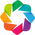

In [85]:
import holoviews as hv
hv.extension('bokeh', 'matplotlib')

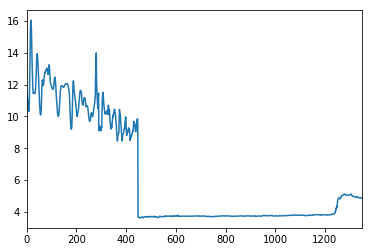

In [86]:
bottom_data.topside_temp.plot()
#bottom_data.pressure.plot()

In [87]:
scatter = (hv.Scatter(bottom_data, 'time','pressure')+
          hv.Scatter(bottom_data, 'time','topside_temp')+ 
          hv.Histogram(np.histogram(bottom_data['tilt'], bins=24)))
scatter

:Layout
   .Scatter.I   :Scatter   [time]   (pressure)
   .Scatter.II  :Scatter   [time]   (topside_temp)
   .Histogram.I :Histogram   [x]   (Frequency)

In [88]:
IDNUMBER.HexView(active_stream='ice',verbose=False)
IDNUMBER.HexSplit(verbose=False)
ice_data = IDNUMBER.Ice(asPandas=True)

FFFFF found


In [89]:
IDNUMBER.HexSplit(verbose=True)


FFFFF found


['',
 '0003403F6512662F21382DAAFE4B07',
 '0004403F657E661321372543FE4B09',
 '0005403F692F662421381BCCFE4B00',
 '0006404067696629213715ABFE4B09',
 '000740416735662A2137155AFE4B03',
 '0008404369A3663B2137155AFE4B10',
 '000940406EFF66692137155AFE4B0A',
 '000A40446893668A2138155AFE4B0C',
 '000B404A6808669E2138155AFE4B0F',
 '000C404D68CF66AB2137155AFE4B0C',
 '000D404E68C766AB2137155AFE4B04',
 '000E404F689766A62136155AFE4B05',
 '000F405368A066B02137155AFE4B0F',
 '00104052693A66C92137155AFE4B0B',
 '001140526B5666C42138155AFE4B0E',
 '0012405669B666CF2138155AFE4B09',
 '001340566A6E66C521371571FE4B0B',
 '00144059698966CC21371DCBFE4B07',
 '0015405B673366AA21381E09FE4B0D',
 '0016405A66DC668C21382015FE4B0E',
 '0017405C65A7667321382CCEFE4B06',
 '0018405C665B666B21374534FE4B09',
 '0019405C6587664321383117FE4B17']

In [90]:
IDNUMBER.Ice(asPandas=True)

,time,pressure,topside_temp,topside_temp_ADC,underside_temp,underside_temp_ADC,temp_ref,par,fluor,tilt
1,10800,0.019226,1.367966,25874,1.172492,26159,8504,226.433699,0,7
2,14400,0.019226,1.285370,25982,1.193677,26131,8503,184.769123,0,9
3,18000,0.019226,0.578594,26927,1.180811,26148,8504,137.835945,0,0
4,21600,0.019531,0.914634,26473,1.177029,26153,8503,107.444630,0,9
5,25200,0.019836,0.953532,26421,1.176273,26154,8503,105.875671,0,3
6,28800,0.020447,0.493747,27043,1.163420,26171,8503,105.875671,0,16
7,32400,0.019531,-0.480051,28415,1.128689,26217,8503,105.875671,0,10
8,36000,0.020752,0.693344,26771,1.103815,26250,8504,105.875671,0,12
9,39600,0.022583,0.796220,26632,1.088757,26270,8504,105.875671,0,15
10,43200,0.023499,0.649122,26831,1.078976,26283,8503,105.875671,0,12


In [91]:
scatter = (hv.Scatter(ice_data, 'time','pressure')+
          hv.Scatter(ice_data, 'time','topside_temp')+ 
          hv.Histogram(np.histogram(ice_data['tilt'], bins=24)))
scatter

:Layout
   .Scatter.I   :Scatter   [time]   (pressure)
   .Scatter.II  :Scatter   [time]   (topside_temp)
   .Histogram.I :Histogram   [x]   (Frequency)

In [92]:
hxv = IDNUMBER.HexView(active_stream='profile',verbose=True)
hs = IDNUMBER.HexSplit(verbose=True)
pro_data = IDNUMBER.Profile(asPandas=True)

FFFFF found


In [93]:
hs[98:110]

['0947726C6679155AFE4B0A',
 '0960720F667B155AFE4B08',
 '097971B1667C155AFE4B07',
 '09927154667D155AFE4B05',
 '09AB70F3667E155AFE4B04',
 '09C470936680155AFE4B08',
 '09DD70336681155AFE4B0B',
 '09F66FD76681155AFE4B0D',
 '0A0F6F7B6682155AFE4B0C',
 '0A286F1C6683155AFE4B0A',
 '0A416EBE6684155AFE4B07',
 '0A5A6E5E6685155AFE4B04']

In [94]:
pro_data

,time,pressure,topside_temp,topside_temp_ADC,par,fluor,tilt
2,1.551454e+09,6.672668,1.205435,26087,106.960384,0,9
3,1.551454e+09,6.670227,1.206195,26086,106.960384,0,9
4,1.551454e+09,6.642761,1.204676,26088,105.875671,0,12
5,1.551454e+09,6.613770,1.204676,26088,105.875671,0,6
6,1.551454e+09,6.584473,1.203916,26089,105.875671,0,9
7,1.551454e+09,6.555786,1.203916,26089,105.875671,0,18
8,1.551454e+09,6.529846,1.203916,26089,105.875671,0,21
9,1.551454e+09,6.502075,1.203916,26089,105.875671,0,16
10,1.551454e+09,6.473389,1.203916,26089,105.875671,0,8
11,1.551454e+09,6.445007,1.203157,26090,105.875671,0,7


In [95]:
try:
    hxv = IDNUMBER.HexView(active_stream='sst',verbose=True)
    hs = IDNUMBER.HexSplit(verbose=True)
    sst_data = IDNUMBER.SST(asPandas=True)
except:
    print("No SST data yet")

No SST data yet


In [96]:
try:
    scatter = (hv.Scatter(sst_data, 'time','pressure')+
          hv.Scatter(sst_data, 'time','topside_temp')+ 
          hv.Histogram(np.histogram(sst_data['tilt'], bins=24)))
    scatter
except:
    print("No SST data yet")

No SST data yet


## Profile Plotting Fun

Since a pandas dataframe is a native output, quicklook plots are very easy to obtain as are output to csv for other software

/Users/bell/anaconda2/envs/py37/lib/python3.7/site-packages/pandas/plotting/_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
/Users/bell/anaconda2/envs/py37/lib/python3.7/site-packages/pandas/plotting/_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boundaries_list[i])
/Users/bell/anaconda2/envs/py37/lib/python3.7/site-packages/pandas/plotting/_misc.py:100: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[i])


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x31c34b588>,
      dtype=object)

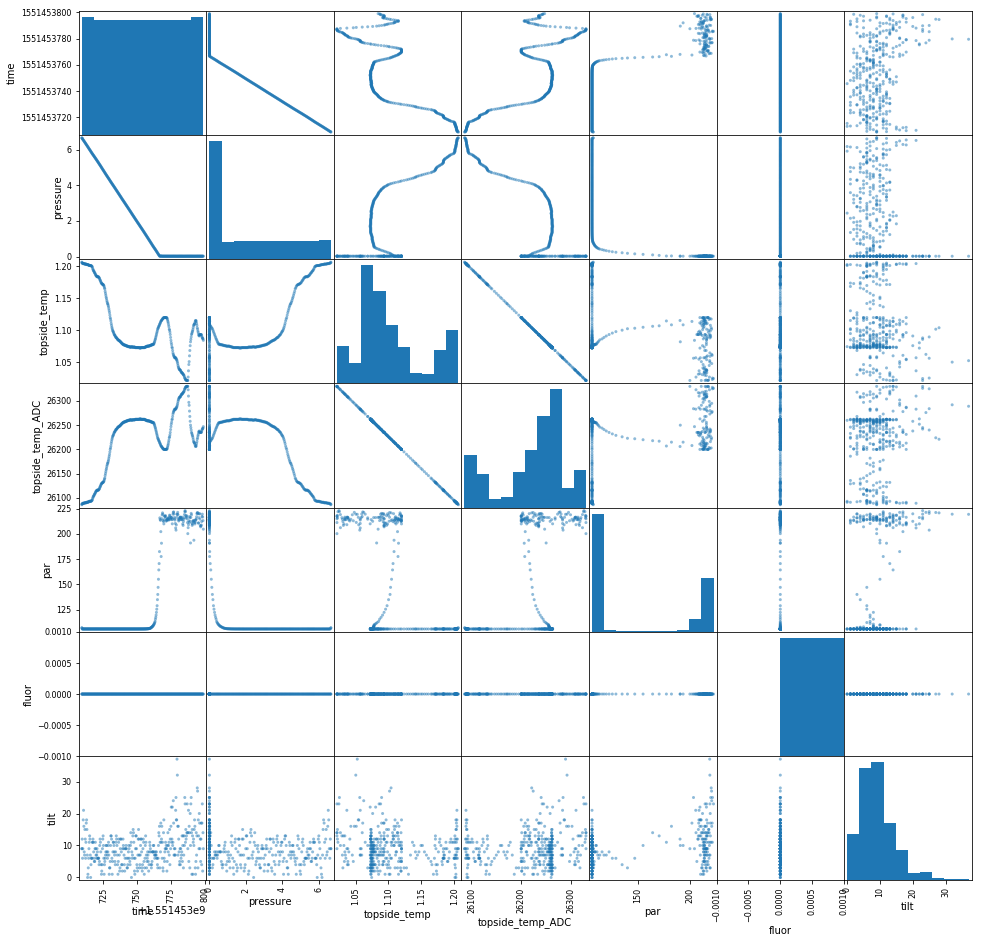

In [97]:
%matplotlib inline
pd.plotting.scatter_matrix(pro_data, figsize=(16, 16))

### Convert elapse time to datetime

In [98]:
from netCDF4 import num2date
pro_data['datetime'] =[num2date(x['time'],'seconds since 1970-1-1') for i,x in pro_data.iterrows()]

Profile data spells out the profile start time which is used to create the "datetime" variable

In [99]:
pro_data['datetime'][:10]

2    2019-03-01 15:21:49.000
3    2019-03-01 15:21:49.000
4    2019-03-01 15:21:49.250
5    2019-03-01 15:21:49.500
6    2019-03-01 15:21:49.750
7    2019-03-01 15:21:50.000
8    2019-03-01 15:21:50.250
9    2019-03-01 15:21:50.500
10   2019-03-01 15:21:50.750
11   2019-03-01 15:21:51.000
Name: datetime, dtype: datetime64[ns]

Bottom and Ice data start marking time from the "Unit_Start_Time" and "Unit_Release_Time" which should be incorporated into the config file

In [100]:
print(yaml.dump(IDNUMBER.config, default_flow_style=False))

UnitID: 300434063925210
Unit_Release_Time: '2019-3-1 00:00:00'
Unit_Start_Time: '2018-9-22 08:00:00'
fluor_cal:
  offset: 0
  slope: 0
par_cal:
  offset: 0
  slope: 0.01414
sample_interval:
  bottom: 3600
  ice: 3600
  sst: 10800
topside_temp_cal:
  Acoef: 0.00123198
  Bcoef: 0.000516452
  Ccoef: 1.53301e-06
underside_temp_cal:
  Acoef: 0.00121562
  Bcoef: 0.000522393
  Ccoef: 1.41501e-06



In [101]:
bottom_data['datetime'] =[num2date(x['time'],'seconds since '+ str(IDNUMBER.config['Unit_Start_Time']) ) for i,x in bottom_data.iterrows()]

In [102]:
bottom_data.head(60)

,time,pressure,topside_temp,topside_temp_ADC,underside_temp,underside_temp_ADC,temp_ref,par,fluor,tilt,datetime
1,0,0.014954,11.433849,15803,11.475251,15781,8505,105.875671,0,77,2018-09-22 08:00:00
2,3600,0.014954,11.259116,15935,11.342578,15881,8505,105.875671,0,78,2018-09-22 09:00:00
3,7200,0.015259,11.134361,16030,11.221343,15973,8505,105.875671,0,79,2018-09-22 10:00:00
4,10800,0.016174,10.998733,16134,11.077413,16083,8504,105.875671,0,80,2018-09-22 11:00:00
5,14400,0.016479,10.910580,16202,10.988989,16151,8505,105.875671,0,78,2018-09-22 12:00:00
6,18000,0.016174,10.776557,16306,10.851981,16257,8504,105.875671,0,78,2018-09-22 13:00:00
7,21600,0.017090,10.551915,16482,10.731319,16351,8504,105.875671,0,78,2018-09-22 14:00:00
8,25200,0.017700,10.311144,16673,10.511269,16524,8504,105.875671,0,78,2018-09-22 15:00:00
9,28800,0.018311,10.338719,16651,10.445632,16576,8504,105.875671,0,76,2018-09-22 16:00:00
10,32400,0.018921,10.579848,16460,10.523918,16514,8504,105.875671,0,77,2018-09-22 17:00:00


In [103]:
ice_data['datetime'] =[num2date(x['time'],'seconds since '+ str(IDNUMBER.config['Unit_Release_Time']) ) for i,x in ice_data.iterrows()]
ice_data['datetime']

1    2019-03-01 03:00:00
2    2019-03-01 04:00:00
3    2019-03-01 05:00:00
4    2019-03-01 06:00:00
5    2019-03-01 07:00:00
6    2019-03-01 08:00:00
7    2019-03-01 09:00:00
8    2019-03-01 10:00:00
9    2019-03-01 11:00:00
10   2019-03-01 12:00:00
11   2019-03-01 13:00:00
12   2019-03-01 14:00:00
13   2019-03-01 15:00:00
14   2019-03-01 16:00:00
15   2019-03-01 17:00:00
16   2019-03-01 18:00:00
17   2019-03-01 19:00:00
18   2019-03-01 20:00:00
19   2019-03-01 21:00:00
20   2019-03-01 22:00:00
21   2019-03-01 23:00:00
22   2019-03-02 00:00:00
23   2019-03-02 01:00:00
Name: datetime, dtype: datetime64[ns]

In [104]:
try:
    sst_data['datetime'] =[num2date(x['time'],'seconds since 1970-1-1') for i,x in sst_data.iterrows()]
    sst_data['datetime']
except:
    print("No SST data")

No SST data


### Saving Data to be used in other software

simple as sending the pandas dataframe to csv

In [105]:
try:
    ice_data.to_csv(instid + '/'+year + '/' + instid+'_ice_data.csv')
except:
    print("No under Ice data")
try:
    sst_data.to_csv(instid + '/'+year + '/' + instid+'_sst_data.csv')
except:
    print("No SST data")
try:
    bottom_data.to_csv(instid + '/'+year + '/' + instid+'_bottom_data.csv')
except:
    print("No bottom data")  
try:
    pro_data.to_csv(instid + '/'+year + '/' + instid+'_profile_data.csv')
except:
    print("No bottom data")

No SST data


## Timeseries Plots of Bottom/Ice/SST

*Bottom*

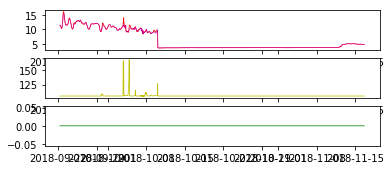

In [106]:
fig = plt.figure(1,figsize=(6,2.5))
### CTD Temperature
ax1 = plt.subplot(3, 1, 1)
plt.plot(bottom_data.datetime,bottom_data.topside_temp,'r',linewidth=.75)
plt.plot(bottom_data.datetime,bottom_data.underside_temp,'m',linewidth=.5)
### Par
ax1 = plt.subplot(3, 1, 2)
plt.plot(bottom_data.datetime,bottom_data.par,'y',linewidth=.75)
### Chlor
ax1 = plt.subplot(3, 1, 3)
plt.plot(bottom_data.datetime,bottom_data.fluor,'g',linewidth=.75)


### TODO:

+ ~~SST encode equations~~
+ ~~output to csv, output specific plots~~
+ output as archive file (netcdf)
+ ~~input configuration file for coeficients to eliminate hard coding~~
+ input configuration file for netcdf output
+ Update Documentation and comments
+ ~~Collapse~~ 
 - ~~equations into one module of "equations"~~
 - ~~uint conversion into module~~
+ ~~prevent analysis of one type to work on different file~~
+ move pandas datetime calculations to class module
    - optionally reindex on time   
+ config file and report file to draw meta-data from
+ ~~output raw temperature probe data~~
+ email reminders when release is supposed to have let go and when data has started (AKUTAN)
+ validate all message keys (images at start of document
+ ~~SBD - Stitch Routine~~
+ when stitching data, remove any preexisting data in working directory (it appends to it if you don't and I don't know why)